In [2]:
import os
import itertools
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense , Flatten , MaxPooling2D, Activation,BatchNormalization,Dropout


In [3]:
data=("/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset")

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

df = create_dataframe(data)

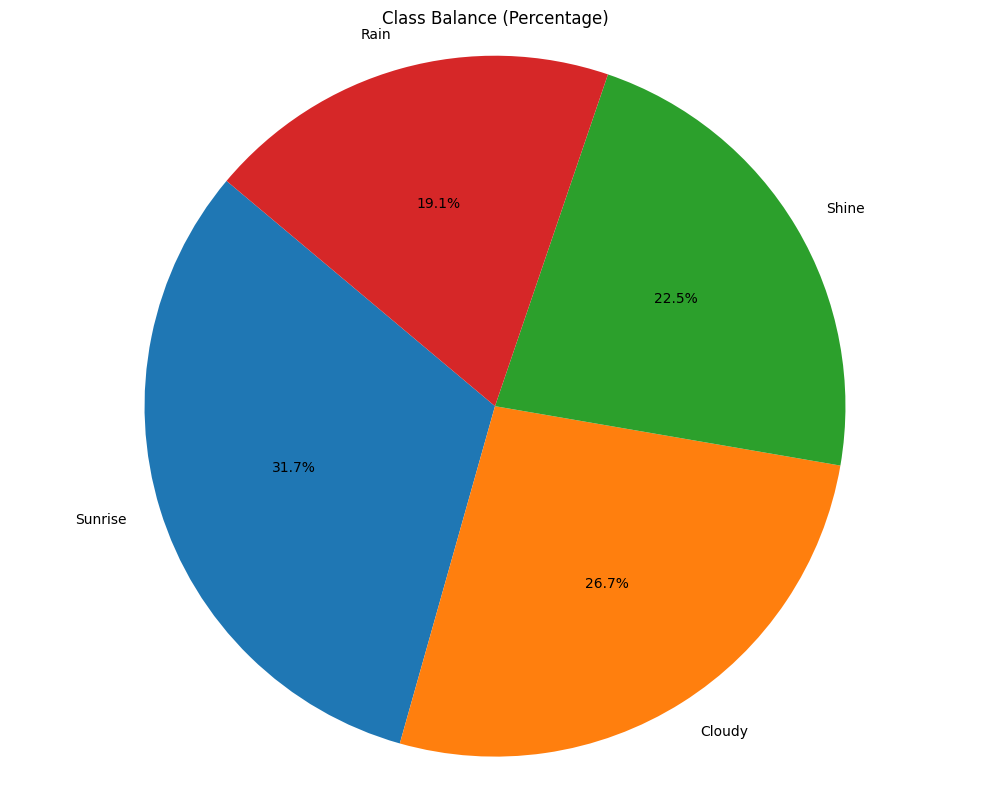

In [4]:
# Calculate class counts
class_counts = df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,shuffle=True)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator without augmentation for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data,
    x_col="Filepaths",  # Column containing file paths
    y_col="Labels",     # Column containing labels
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

# Testing Generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 900 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.


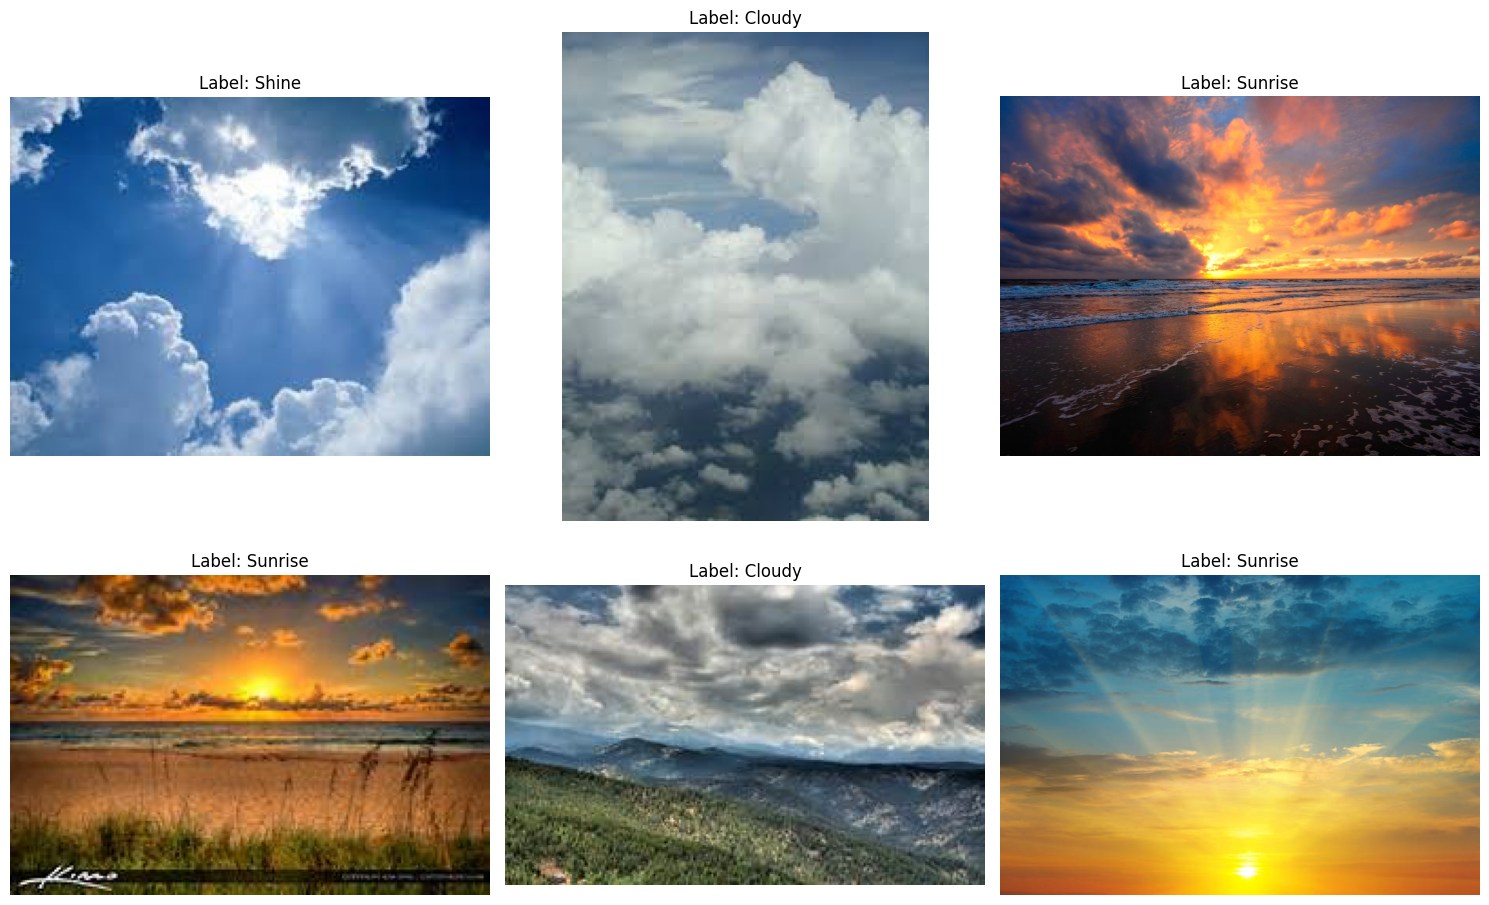

In [11]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

In [14]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
                                                     pooling = 'max' )

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(4 , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = model.fit(
    x= train_generator ,
    validation_data= test_generator ,
    epochs= 20 , verbose = 1 ,
    validation_steps = None)
    

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1710216162.152763     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/29 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6663 - loss: 1.1803  

W0000 00:00:1710216196.410794     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7207 - loss: 0.9820

W0000 00:00:1710216202.161741     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7247 - loss: 0.9677 - val_accuracy: 0.8356 - val_loss: 0.6593
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.9496 - loss: 0.1242 - val_accuracy: 0.9244 - val_loss: 0.3165
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.9743 - loss: 0.0846 - val_accuracy: 0.9422 - val_loss: 0.1913
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.9774 - loss: 0.0829 - val_accuracy: 0.9600 - val_loss: 0.1566
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - accuracy: 0.9738 - loss: 0.1070 - val_accuracy: 0.9689 - val_loss: 0.1221
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9824 - loss: 0.0424 - val_accuracy: 0.9644 - val_loss: 0.1094
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9904 - loss: 0.1047 - val_accuracy: 0.9644 - val_loss: 0.1266
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.9896 - loss: 0.0318 - val_accuracy: 0.9778 -

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9929 - loss: 0.0280
Test Accuracy: 0.9822221994400024


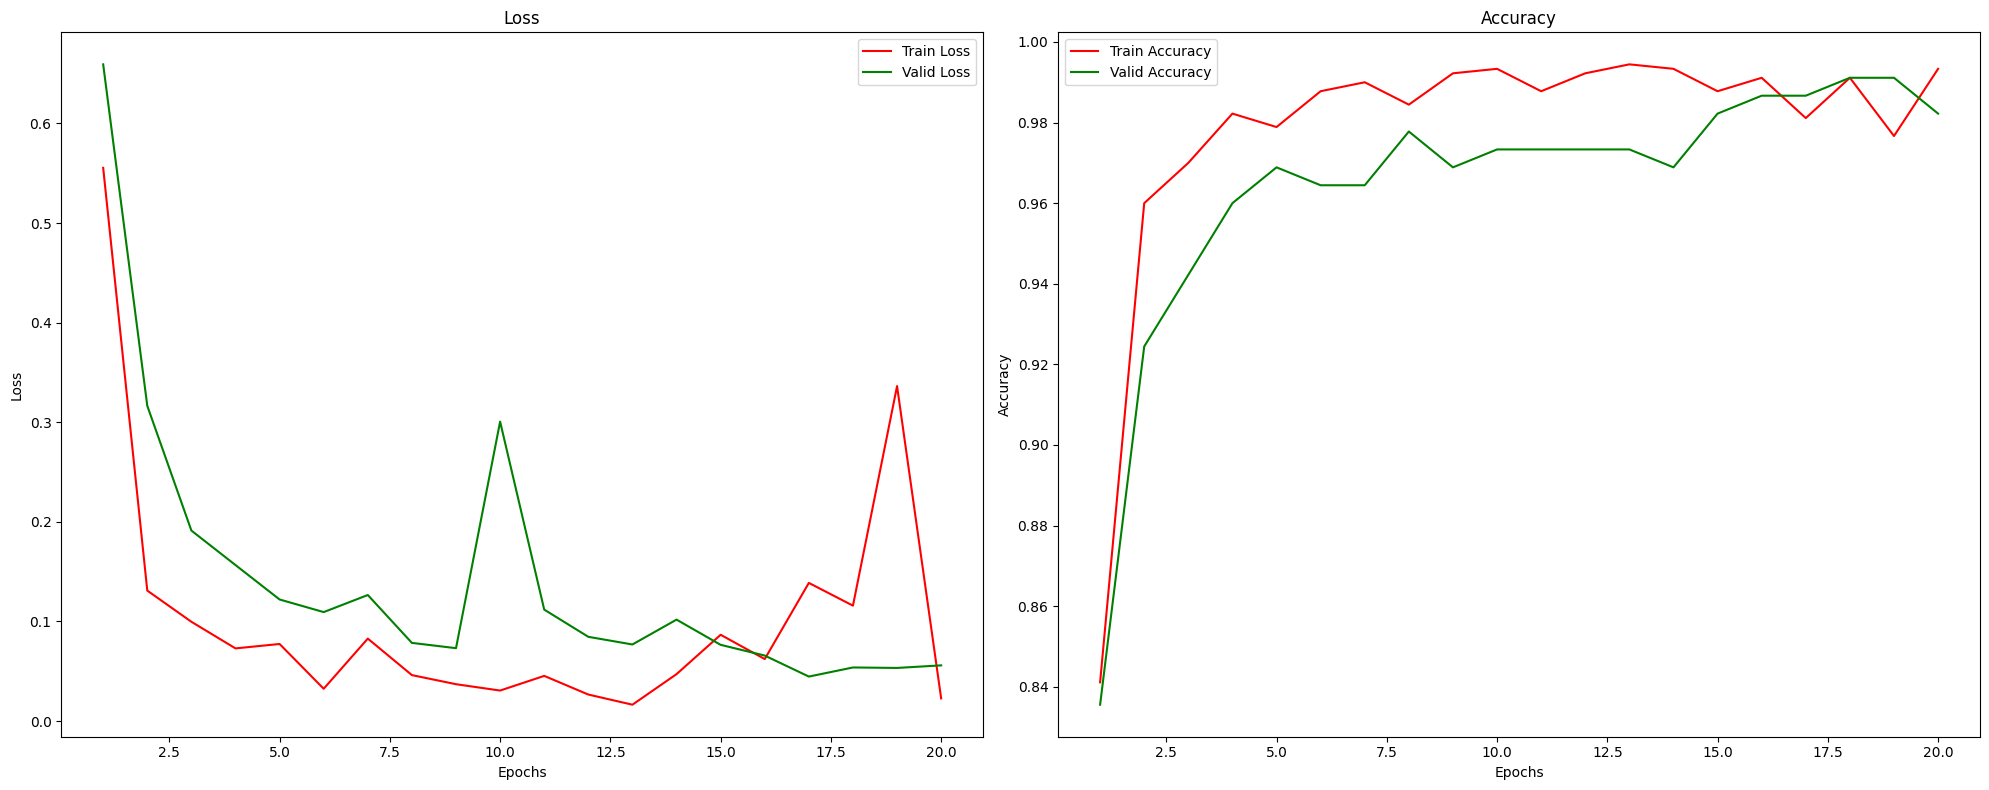

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()